In [1]:
import sys

MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
import tqdm
from sklearn.preprocessing import MinMaxScaler

In [3]:
from utils.dataset import SlowEarthquakeDataset
from utils.dl_models import save_model

In [4]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
EXPERIMENT = "p4581"
TS_COLUMN = "det_shear_stress"

dataset = SlowEarthquakeDataset([EXPERIMENT])
ds_exp = dataset[EXPERIMENT]
X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]

ts_data = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[ds_exp["hdrs"]["X"], *ds_exp["hdrs"]["Y"], ds_exp["hdrs"]["t"]],
)

ts_data = ts_data.dropna(axis=1)
ts_data.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.002811,1.29911,2.99288,0.000
1,0.002731,1.29903,2.99008,0.001
2,0.002231,1.29853,2.98854,0.002
3,0.002411,1.29871,2.98849,0.003
4,0.002241,1.29854,2.99069,0.004


In [6]:
ts_data = ts_data.rolling(window=int(1e3), step=int(1e3)).mean().dropna()
ts_data = ts_data.reset_index(drop=True)
ts_data = ts_data.dropna()
ts_data.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.010441,1.306805,2.989703,0.500503
1,0.023812,1.320308,2.989567,1.500508
2,0.033829,1.330455,2.989649,2.500513
3,0.040971,1.337728,2.989704,3.500518
4,0.045985,1.342874,2.989764,4.500523


In [7]:
# AIRLINES_CSV_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
# TS_COLUMN = "Passengers"

# ts_data = pd.read_csv(AIRLINES_CSV_URL)
# ts_data.head()

In [8]:
def create_sequences(data, lookback, forecast):
    xs, ys = [], []
    for i in range(len(data) - lookback - forecast - 1):
        x = data[i : (i + lookback)]
        y = data[(i + lookback) : (i + lookback + forecast)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


lookback = 5
forecast = 1

X, y = create_sequences(ts_data[TS_COLUMN].values, lookback, forecast)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

train_size = int(len(y) * 0.8)
X_train, X_test = scaler_X.fit_transform(X[:train_size]), scaler_X.transform(
    X[train_size:]
)
y_train, y_test = scaler_y.fit_transform(y[:train_size]), scaler_y.transform(
    y[train_size:]
)

X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

loader = data.DataLoader(
    data.TensorDataset(X_train, y_train), shuffle=True, batch_size=64
)

using device: cuda


In [9]:
class LSTM(nn.Module):
    def __init__(self, n_variates, hidden_size, num_layers, output_steps):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            n_variates, hidden_size, num_layers, batch_first=True
        )
        self.fc1 = nn.Linear(num_layers * hidden_size, 128)
        self.fc2 = nn.Linear(128, output_steps)
        self.relu = nn.ReLU6()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(
            x.device
        )
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(
            x.device
        )

        _, (hn, cn) = self.lstm(x, (h0, c0))
        hn = hn.view(x.size(0), self.num_layers * self.hidden_size)
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out


n_variates = 1
hidden_size = 50
num_layers = 1
output_steps = forecast

model = LSTM(n_variates, hidden_size, num_layers, output_steps).to(device)

In [10]:
learning_rate = 1e-3
num_epochs = int(5e2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

pbar = tqdm.tqdm(range(num_epochs))

for epoch in pbar:

    model.train()
    for X_batch, y_batch in loader:
        outputs = model(X_batch.unsqueeze(-1))
        optimizer.zero_grad()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():
        y_pred = model(X_train.unsqueeze(-1))
        y_pred = torch.Tensor(scaler_y.inverse_transform(y_pred.cpu()))
        y_train_ = torch.Tensor(scaler_y.inverse_transform(y_train.cpu()))
        train_rmse = np.sqrt(criterion(y_pred, y_train_))

        y_pred = model(X_test.unsqueeze(-1))
        y_pred = torch.Tensor(scaler_y.inverse_transform(y_pred.cpu()))
        y_test_ = torch.Tensor(scaler_y.inverse_transform(y_test.cpu()))
        test_rmse = np.sqrt(criterion(y_pred, y_test_))

    pbar.set_description(
        f"Epoch [{epoch+1}/{num_epochs}], Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}"
    )

Epoch [500/500], Train RMSE: 0.0382, Test RMSE: 0.0420: 100%|██████| 500/500 [00:06<00:00, 76.74it/s]


In [11]:
with torch.no_grad():
    y_pred = model(X_test.unsqueeze(-1))
    y_pred = torch.Tensor(scaler_y.inverse_transform(y_pred.cpu()))
    y_test_ = torch.Tensor(scaler_y.inverse_transform(y_test.cpu()))
    test_rmse = np.sqrt(criterion(y_pred, y_test_))
    print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 0.0420


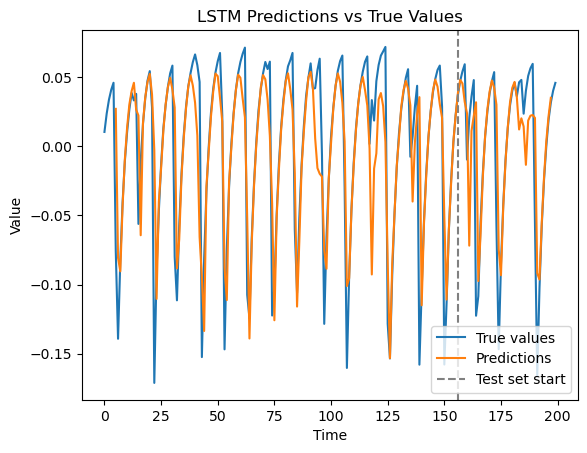

In [12]:
ith_output = 0  # 0 for the immediate next timestep, 1 for the next to next, 2 for the next to next to next ....

with torch.no_grad():
    train_outputs = scaler_y.inverse_transform(
        model(X_train.unsqueeze(-1)).cpu().numpy()
    )[:, ith_output]
    test_outputs = scaler_y.inverse_transform(
        model(X_test.unsqueeze(-1)).cpu().numpy()
    )[:, ith_output]
all_outputs = np.concatenate((train_outputs, test_outputs))

test_start_index = len(ts_data) - len(y_test) - lookback

plt.plot(ts_data[TS_COLUMN].values, label="True values")
plt.plot(
    range(lookback + ith_output, lookback + len(all_outputs) + ith_output),
    all_outputs,
    label="Predictions",
)
plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("LSTM Predictions vs True Values")
plt.show()

In [13]:
save_model(
    model,
    ts_data[TS_COLUMN].values,
    all_outputs,
    range(lookback, lookback + len(all_outputs)),
)

model saved to /gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/results/p341cam_2024-01-18T00:50:06_model.pth
input & predictions saved to /gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/results/p341cam_2024-01-18T00:50:06_data.pt
